## Import Lib

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
palette = itertools.cycle(sns.color_palette())

from func import get_data

# fix random generator seed (for reproducibility of results)
#np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## Import Data

In [2]:
# Read the CSV file into a pandas DataFrame and display the first few rows
path_ella = 'C:/Users/ellad/Desktop/MB_ML/Projekt/train_heart.csv'
path_train = './train_heart.csv'
path_test = './test_heart.csv'

col = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

[X_train,y_train,X_test,y_test] = get_data(path_train,path_test,col)


print("Training Dataset size:", len(X_train))
print("Test Dataset size:", len(X_test))

print('Training data shape: ',X_train.shape)
print('Test data shape: ',X_test.shape)
#________________________________________________



Training Dataset size: 1025
Test Dataset size: 303
Training data shape:  (1025, 30)
Test data shape:  (303, 30)


## Simple sklearn LogReg

In [3]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
#print("predictions:", y_hat)
#print("true values:", y_test)

#evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Accuracy: 0.8778877887788779


## Complicated LogReg

In [4]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=(alpha + X.matmul(beta))), obs=obs)
        
    return y

# Prepare data for Pyro

X_train_tensor = torch.tensor(X_train.astype('float')).float()
y_train_tensor = torch.tensor(y_train).float()

In [ ]:
def model_2(X, z, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept

    # Priors for the regression coeffcients
    beta_0  = pyro.sample("beta_0", dist.Normal(torch.zeros(input_dim, n_cat), torch.ones(input_dim, n_cat)).to_event()) 
    beta_1  = pyro.sample("beta_1", dist.Normal(torch.zeros(input_dim, n_cat), torch.ones(input_dim, n_cat)).to_event()) 
    beta_2  = pyro.sample("beta_2", dist.Normal(torch.zeros(input_dim, n_cat), torch.ones(input_dim, n_cat)).to_event()) 
    beta_3  = pyro.sample("beta_3", dist.Normal(torch.zeros(input_dim, n_cat), torch.ones(input_dim, n_cat)).to_event()) 


    with pyro.plate("data"):
        if z == 0.0:
            y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta_0)), obs=obs)
        if z == 1.0:
            y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta_1)), obs=obs)
        if z == 2.0:
            y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta_2)), obs=obs)
        if z == 3.0:
            y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta_3)), obs=obs)
        
    return y

In [5]:


n_cat = 2

# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_tensor, n_cat, y_train_tensor)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

torch.Size([30, 2])
torch.Size([30, 2])
[0] ELBO: 848.8
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torc

In [7]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train_tensor, n_cat, y_train_tensor-1)

torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])
torch.Size([30, 2])


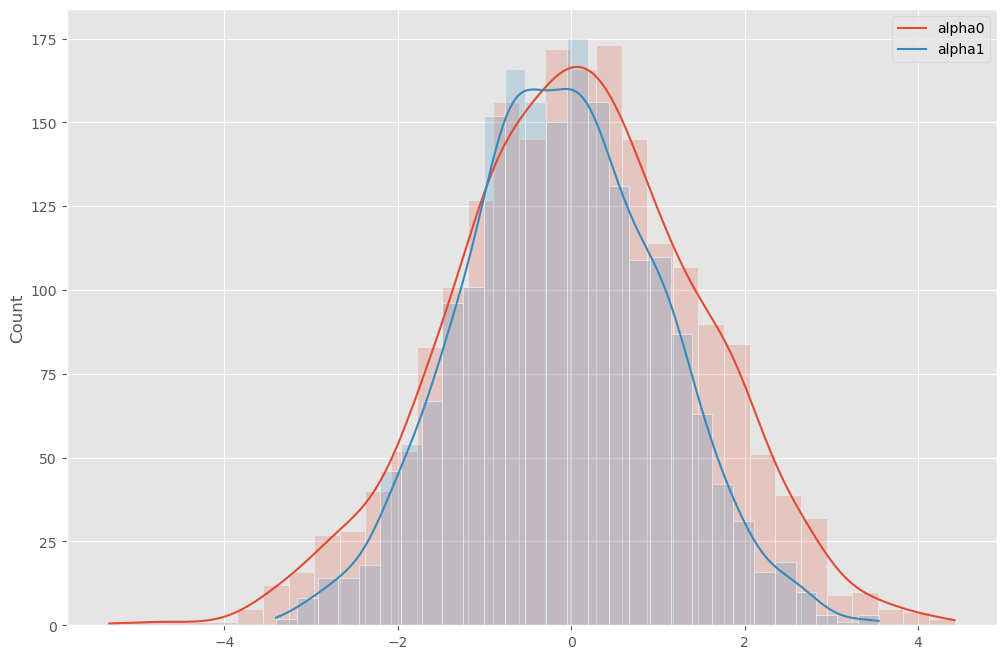

In [8]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

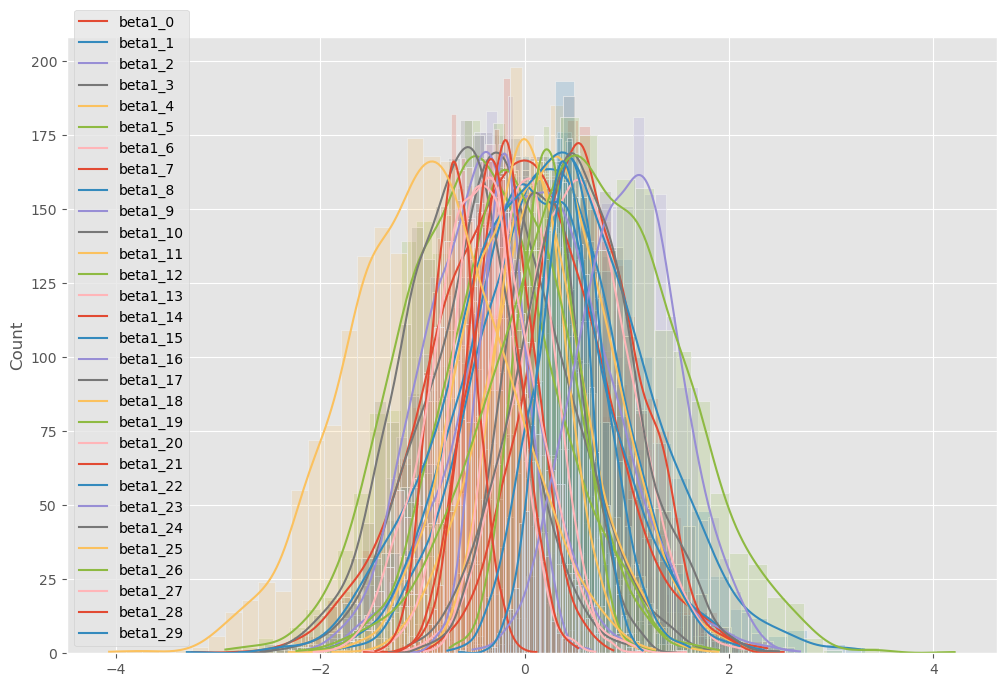

In [9]:
samples_beta = samples['beta'].detach().squeeze()
for d in range(X_train.shape[1]):
    sns.histplot(samples_beta[:,d,0], kde=True, alpha=0.2)
plt.legend(["beta1_%d" % d for d in range(X_train.shape[1])])
plt.show()

In [12]:
alpha_hat = samples_alpha.mean(axis=0).numpy()
beta_hat = samples_beta.mean(axis=0).numpy()

# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
#print("predictions:", y_hat-1)
#print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum((y_hat-1) == y_test) / len(y_test))

# Der skal -1 på y_hat for den giver predictions med 1 og 2 istedet for 0 og 1

Accuracy_new: 0.8811881188118812
